<a href="https://colab.research.google.com/github/Hwan0130/Bioinformatics_intern/blob/main/Enformer_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 딥러닝 기반 전장유전체 유전변이 기능예측 분석 튜토리얼

고려대학교 인간유전체 연구실 (안준용)

Update: 2022/10/29

딥러닝 기반 전장유전체 유전변이 기능예측 분석 튜토리얼에 오신 여러분을 환영합니다.

본 튜토리얼에서는 딥러닝 모델 Enformer를 이용하여, 유전변이 기능예측 튜토리얼을 진행합니다. 현재 튜토리얼은 구글 코랩에서 사용할 수 있도록 작성되었습니다. 튜토리얼에 사용할 데이터는 노트북 내에 링크가 있으니, 실행하며 다운로드를 받으시면 됩니다. 코드를  구동하기 전에, 오른쪽 상단에 있는 Connect 버튼을 눌러서 구글 코랩 세션을 실행해주세요.


## 라이브러리 인스톨 및 데이터 다운로드

우선, 본 튜토리얼에 활용할 라이브러리를 설치합니다. Enformer 모델을 활용하기 위해, [kipoi](https://kipoi.org/) 라이브러리를 이용하여 모델 데이터를 연결하여 사용할 계획입니다.

In [ ]:
# kipoi 설치
!pip install kipoi

In [ ]:
# 분석에 필요한 라이브러리 불러오기
# 텐서 및 데이터 다운로드 관련
import tensorflow as tf
import tensorflow_hub as hub
import joblib
import gzip
import kipoiseq
from kipoiseq import Interval
import pyfaidx
import pandas as pd
import numpy as np

## 데이터 테이블
from google.colab import data_table

## 시각화
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

딥러닝 분석에 사용할 enformer 모델을 tfhub에서 다운로드 받습니다. 모델은 enformer 논문 ([Avsec et al. 2021](https://www.nature.com/articles/s41592-021-01252-x))에서 pre-training을 한 모델을 사용합니다.

In [ ]:
# Enformer 모델
model_path = 'https://tfhub.dev/deepmind/enformer/1'

해당 분석에 활용할 인간 참조유전체 파일을 다운로드 합니다. 모델은 hg38 버젼으로 작성되어 있으므로, 이에 매칭되는 파일을 UCSC Genome Browser에서 다운로드 받습니다.

In [ ]:
# 인간 참조유전체 파일
fasta_file = '/root/data/genome.fa'

!mkdir -p /root/data

# 인간 유전체 fasta 파일 다운로드
!wget -O - http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gunzip -c > {fasta_file}
pyfaidx.Faidx(fasta_file)
!ls /root/data

--2025-01-06 01:41:54--  http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
Resolving hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.cse.ucsc.edu (hgdownload.cse.ucsc.edu)|128.114.119.163|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 983659424 (938M) [application/x-gzip]
Saving to: ‘STDOUT’

-                   100%[===================>] 938.09M  21.8MB/s    in 32s     

2025-01-06 01:42:26 (29.3 MB/s) - written to stdout [983659424/983659424]

genome.fa  genome.fa.fai


본 튜토리얼에서는 ClinVar 데이터베이스에서 질병 연관 유전변이가 저장된 VCF 파일을 다운로드 받습니다. 필요에 따라, 환자군의 전장유전체 파일을 사용할 수 있습니다. 튜토리얼은 편의를 위해, 공개된 데이터를 활용합니다.

In [ ]:
# 유전변이 VCF 파일
vcf_path = '/root/data/clinvar.vcf.gz'

# ClinVar 환자 유전변이 데이터 다운로드
!wget https://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/clinvar.vcf.gz -O /root/data/clinvar.vcf.gz

--2025-01-06 01:43:26--  https://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/clinvar.vcf.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.31, 130.14.250.7, 130.14.250.10, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105254882 (100M) [application/x-gzip]
Saving to: ‘/root/data/clinvar.vcf.gz’

/root/data/clinvar. 100%[===================>] 100.38M  49.0MB/s    in 2.0s    

2025-01-06 01:43:29 (49.0 MB/s) - ‘/root/data/clinvar.vcf.gz’ saved [105254882/105254882]



## 예측을 위한 모델 세팅

Enformer 예측에 사용할 input 시퀀스의 길이 및 모델 데이터 (e.g. DNAse-seq, Chip-seq, CAGE-seq 등등) 항목을 설정합니다. 본 튜토리얼에서는 393,216 bp의 window를 갖고 딥러닝 예측을 시행합니다. 모델 데이터의 목록은 Enformer 원 연구와 동일하게 사용합니다.

In [ ]:
SEQUENCE_LENGTH = 393216

targets_txt = 'https://raw.githubusercontent.com/calico/basenji/master/manuscripts/cross2020/targets_human.txt'
df_targets = pd.read_csv(targets_txt, sep='\t')

# 어떤 track 들이 있는지 확인하기
data_table.enable_dataframe_formatter()
df_targets

,index,genome,identifier,file,clip,scale,sum_stat,description
0,0,0,ENCFF833POA,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:cerebellum male adult (27 years) and mal...
1,1,0,ENCFF110QGM,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:frontal cortex male adult (27 years) and...
2,2,0,ENCFF880MKD,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:chorion
3,3,0,ENCFF463ZLQ,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:Ishikawa treated with 0.02% dimethyl sul...
4,4,0,ENCFF890OGQ,/home/drk/tillage/datasets/human/dnase/encode/...,32,2,mean,DNASE:GM03348
...,...,...,...,...,...,...,...,...
5308,5308,0,CNhs14239,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:epithelioid sarcoma cell line:HS-ES-2R
5309,5309,0,CNhs14240,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:squamous cell lung carcinoma cell line:RE...
5310,5310,0,CNhs14241,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:gastric cancer cell line:GSS
5311,5311,0,CNhs14244,/home/drk/tillage/datasets/human/cage/fantom/C...,384,1,sum,CAGE:carcinoid cell line:NCI-H727


In [ ]:
class Enformer:

  def __init__(self, tfhub_url):
    self._model = hub.load(tfhub_url).model

  def predict_on_batch(self, inputs):
    predictions = self._model.predict_on_batch(inputs)
    return {k: v.numpy() for k, v in predictions.items()}

  @tf.function
  def contribution_input_grad(self, input_sequence,
                              target_mask, output_head='human'):
    input_sequence = input_sequence[tf.newaxis]

    target_mask_mass = tf.reduce_sum(target_mask)
    with tf.GradientTape() as tape:
      tape.watch(input_sequence)
      prediction = tf.reduce_sum(
          target_mask[tf.newaxis] *
          self._model.predict_on_batch(input_sequence)[output_head]) / target_mask_mass

    input_grad = tape.gradient(prediction, input_sequence) * input_sequence
    input_grad = tf.squeeze(input_grad, axis=0)
    return tf.reduce_sum(input_grad, axis=-1)

class EnformerScoreVariantsRaw:

  def __init__(self, tfhub_url, organism='human'):
    self._model = Enformer(tfhub_url)
    self._organism = organism

  def predict_on_batch(self, inputs):
    ref_prediction = self._model.predict_on_batch(inputs['ref'])[self._organism]
    alt_prediction = self._model.predict_on_batch(inputs['alt'])[self._organism]

    return alt_prediction.mean(axis=1) - ref_prediction.mean(axis=1)

class FastaStringExtractor:

    def __init__(self, fasta_file):
        self.fasta = pyfaidx.Fasta(fasta_file)
        self._chromosome_sizes = {k: len(v) for k, v in self.fasta.items()}

    def extract(self, interval: Interval, **kwargs) -> str:
        # Truncate interval if it extends beyond the chromosome lengths.
        chromosome_length = self._chromosome_sizes[interval.chrom]
        trimmed_interval = Interval(interval.chrom,
                                    max(interval.start, 0),
                                    min(interval.end, chromosome_length),
                                    )
        # pyfaidx wants a 1-based interval
        sequence = str(self.fasta.get_seq(trimmed_interval.chrom,
                                          trimmed_interval.start + 1,
                                          trimmed_interval.stop).seq).upper()
        # Fill truncated values with N's.
        pad_upstream = 'N' * max(-interval.start, 0)
        pad_downstream = 'N' * max(interval.end - chromosome_length, 0)
        return pad_upstream + sequence + pad_downstream

    def close(self):
        return self.fasta.close()

def variant_generator(vcf_file, gzipped=False):
  """Yields a kipoiseq.dataclasses.Variant for each row in VCF file."""
  def _open(file):
    return gzip.open(vcf_file, 'rt') if gzipped else open(vcf_file)

  with _open(vcf_file) as f:
    for line in f:
      if line.startswith('#'):
        continue
      chrom, pos, id, ref, alt_list = line.rstrip('\n').split('\t')[:5]
      # Split ALT alleles and return individual variants as output.
      for alt in alt_list.split(','):
        yield kipoiseq.dataclasses.Variant(chrom=chrom, pos=pos,
                                           ref=ref, alt=alt, id=id)

def one_hot_encode(sequence):
  return kipoiseq.transforms.functional.one_hot_dna(sequence).astype(np.float32)

def variant_centered_sequences(vcf_file, sequence_length, gzipped=False,
                               chr_prefix=''):
  seq_extractor = kipoiseq.extractors.VariantSeqExtractor(
    reference_sequence=FastaStringExtractor(fasta_file))

  for variant in variant_generator(vcf_file, gzipped=gzipped):
    interval = Interval(chr_prefix + variant.chrom,
                        variant.pos, variant.pos)
    interval = interval.resize(sequence_length)
    center = interval.center() - interval.start

    reference = seq_extractor.extract(interval, [], anchor=center)
    alternate = seq_extractor.extract(interval, [variant], anchor=center)

    yield {'inputs': {'ref': one_hot_encode(reference),
                      'alt': one_hot_encode(alternate)},
           'metadata': {'chrom': chr_prefix + variant.chrom,
                        'pos': variant.pos,
                        'id': variant.id,
                        'ref': variant.ref,
                        'alt': variant.alt}}

def plot_tracks(tracks, interval, height=1.5):
  fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
  for ax, (title, y) in zip(axes, tracks.items()):
    ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
    ax.set_title(title)
    sns.despine(top=True, right=True, bottom=True)
  ax.set_xlabel(str(interval))
  plt.tight_layout()

class EnformerScoreVariantsNormalized:

  def __init__(self, tfhub_url, transform_pkl_path,
               organism='human'):
    assert organism == 'human', 'Transforms only compatible with organism=human'
    self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
    with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
      transform_pipeline = joblib.load(f)
    self._transform = transform_pipeline.steps[0][1]  # StandardScaler.

  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)

class EnformerScoreVariantsPCANormalized:

  def __init__(self, tfhub_url, transform_pkl_path,
               organism='human', num_top_features=500):
    self._model = EnformerScoreVariantsRaw(tfhub_url, organism)
    with tf.io.gfile.GFile(transform_pkl_path, 'rb') as f:
      self._transform = joblib.load(f)
    self._num_top_features = num_top_features

  def predict_on_batch(self, inputs):
    scores = self._model.predict_on_batch(inputs)
    return self._transform.transform(scores)[:, :self._num_top_features]

# 논코딩 유전체 부위를 활용한 딥러닝 예측

우선 Enformer 딥러닝 모델을 활용하여, 특정 유전체 부위의 기능을 예측해보도록 하겠습니다. 이를 위해선 genomic interval이 필요하고, 특정 지역을 정희(define)하여, 해당 부위가 어느정도의 전사조절 기능을 갖는지 판별할 수 있습니다.

아래 코드를 이용하여, enformer 모델과 인간 참조유전체 서열 fasta 파일을 불러오겠습니다.

In [ ]:
model = Enformer(model_path)
fasta_extractor = FastaStringExtractor(fasta_file)

[Allou et al. 2021](https://www.nature.com/articles/s41586-021-03208-9#Sec43)에서 보고한 사지체형 발달 이상에 영향을 미치는 논코딩 지역을 조사해보도록 하겠습니다. 이 연구에서는 사지체형 발달 이상을 보이는 환자를 수집하여 조사한 결과 engrailed-1 (EN1) 유전자 앞단에서 300kb 떨어진 지점에서 환자들이 공통적으로 deletion을 갖는다는 것을 찾았습니다. 이 deletion은 크기가 제각각이지만, 공통적으론 염색체 2번의 118,561,492번째부터 118,589,320번째 위치까지 deletion을 형성합니다. 이 부위를 이용하여, 실제 사지발달에 영향을 미치는 조직이 무엇인지 탐색해봅시다.


In [ ]:
target_interval = kipoiseq.Interval('chr2', 118561492, 118589320)

sequence_one_hot = one_hot_encode(fasta_extractor.extract(target_interval.resize(SEQUENCE_LENGTH)))
predictions = model.predict_on_batch(sequence_one_hot[np.newaxis])['human'][0]

해당 지역에 대한 전사조절 기능예측을 완료하였으니, 각 조직에 어느정도의 영향을 미치는지 시각화를 해보도록 하겠습니다. 편의상, 해당 질환에 영향을 미친다고 보고된, 생후 100일 정도의 태아 forelimb 조직 (남녀), 뇌조직 (남녀)을 비교해보겠습니다. 대조군으로 성인 남녀의 췌장 조직을 같이 비교하여 보겠습니다. 다른 조직들은 위에 코드에 사용된 data table explore를 통하여, 인덱스와 조직명을 수정할 수 있습니다.

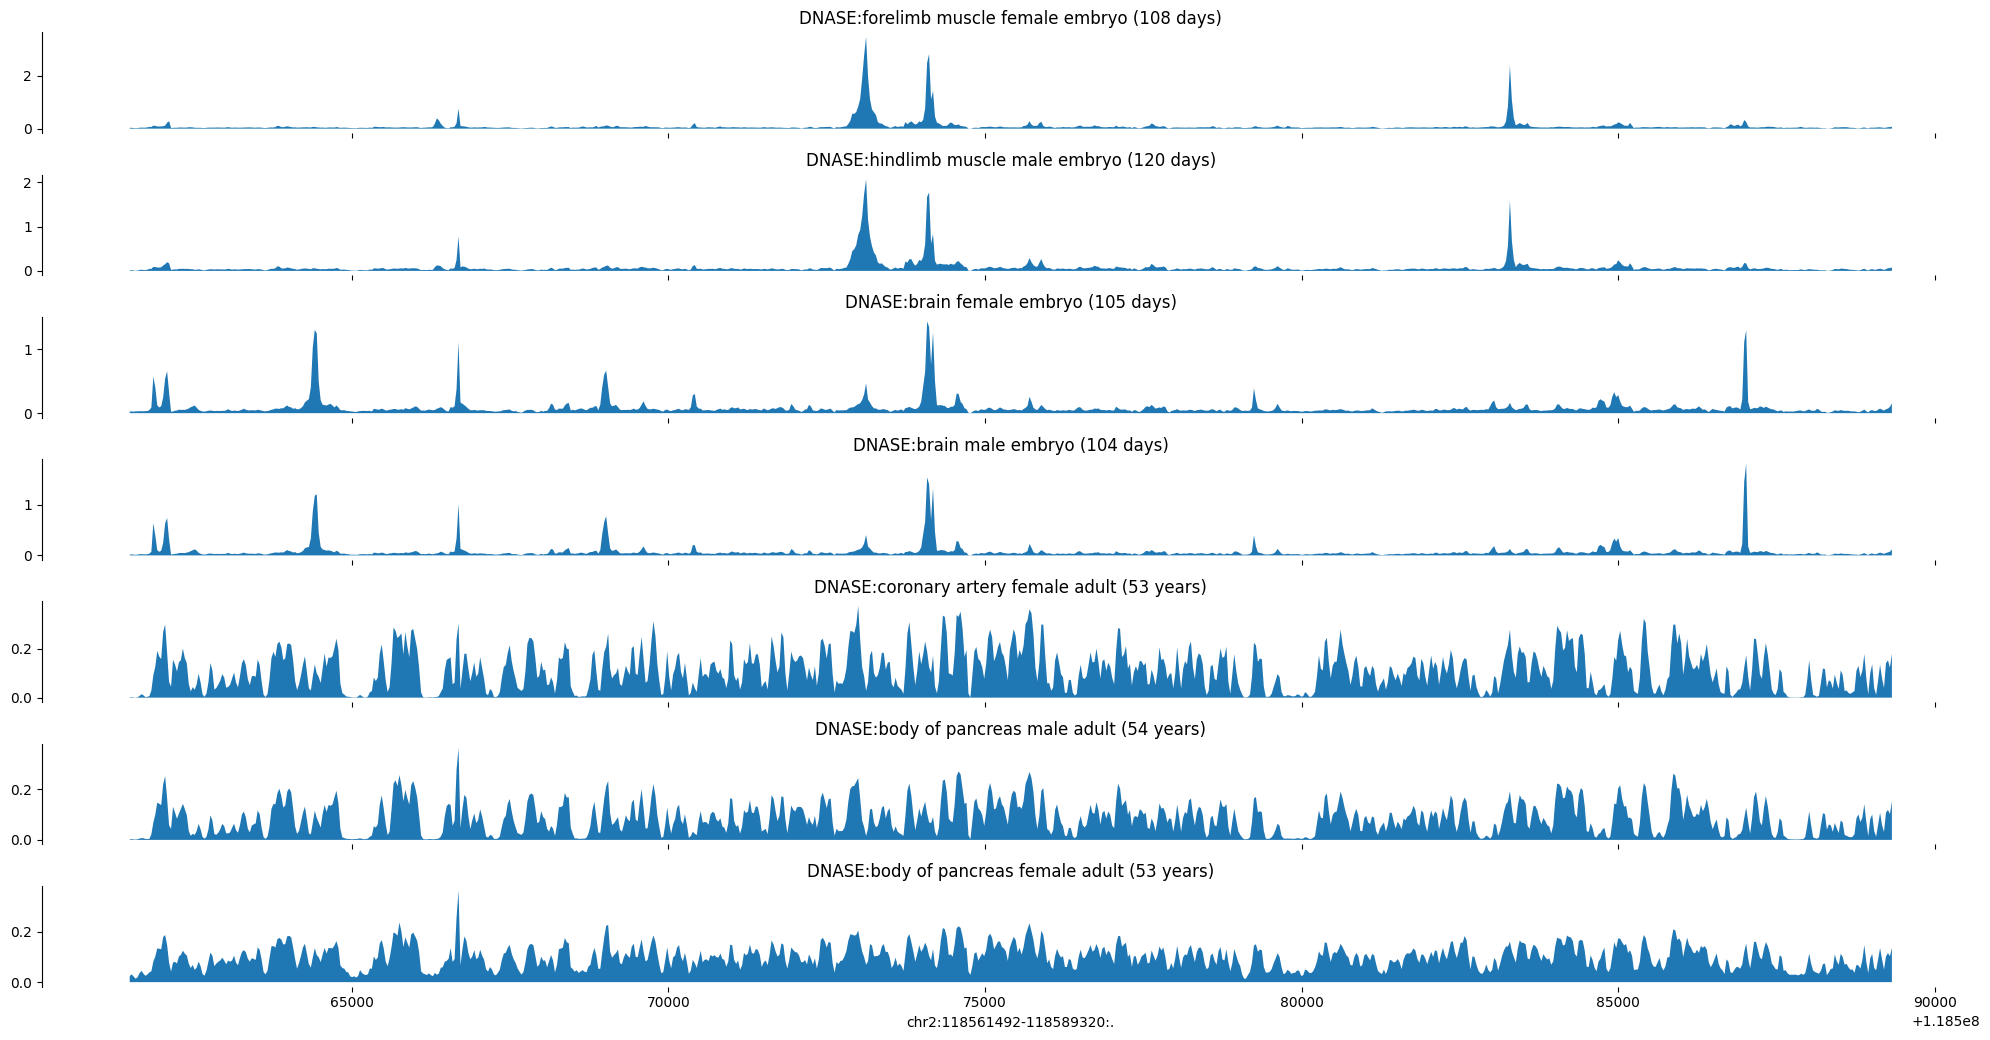

In [ ]:
tracks = {'DNASE:forelimb muscle female embryo (108 days)': predictions[:, 247],
          'DNASE:hindlimb muscle male embryo (120 days)': predictions[:, 358],
          'DNASE:brain female embryo (105 days)': predictions[:, 580],
          'DNASE:brain male embryo (104 days)': predictions[:, 644],
          'DNASE:coronary artery female adult (53 years)': predictions[:, 193],
          'DNASE:body of pancreas male adult (54 years)': predictions[:, 280],
          'DNASE:body of pancreas female adult (53 years)': predictions[:, 371]}
plot_tracks(tracks, target_interval)

위에 보는 그림과 같이, 태아의 조직에서 강한 기능조절 지수가 관찰됩니다. 특히 forelimb는 특정 지역이 기능지수가 2에 가까운 변화들을 갖는 것으로 확인됩니다. 그에 비해, 성년의 조직들에선 매우 낮은 기능조절 지수 및 특정한 조절 부위가 관찰되지 않습니다.

# 유전변이를 이용한 딥러닝 예측

이번에는 질병 연관 유전변이를 이용하여 딥러닝 enformer 예측을 시행합니다. VCF는 변이와 환자 정보를 담고 있는 일종의 유전체 데이터프레임입니다. 여러분이 실제 연구 개발에 사용하는 VCF 파일은 변이를 각 locus (유전체 상의 위치)에서 모든 샘플이 동일하게 기록하고, 각 샘플은 이 변이에 대한 유전형(genotype) 정보를 갖습니다. 다시 말해서, enformer 예측은 각 변이에 대하여 시행을 하게 되고, 이에 대한 score 여부는 각 샘플에 대하여 고유하게 부여가 됩니다.

본 튜토리얼에서는 환자 개인의 유전형 정보를 활용할 수 없으니, 공개된 변이 수준 (variant-level)의 데이터를 활용하여 튜토리얼을 진행합니다. 이를 위해 ClinVar 데이터베이스를 활용하였습니다.

먼저 딥러닝 모델과 enformer 팀에서 미리 공개한 PCA500에 대한 pre-configured 데이터를 불러줍니다.

In [ ]:
transform_path = 'gs://dm-enformer/models/enformer.finetuned.SAD.robustscaler-PCA500-robustscaler.transform.pkl'

enformer_score_variants_all = EnformerScoreVariantsNormalized(model_path, transform_path)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RobustScaler from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator TruncatedSVD from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator Pipeline from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. 

In [ ]:
# 편의상 처음 30개의 변이에 대한 값을 산출합니다
it = variant_centered_sequences(vcf_path, sequence_length=SEQUENCE_LENGTH,
                                gzipped=True, chr_prefix='chr')
example_list = []
for i, example in enumerate(it):
  if i >= 30:
    break
  variant_scores = enformer_score_variants_all.predict_on_batch(
      {k: v[tf.newaxis] for k,v in example['inputs'].items()})[0]
  variant_scores = {f'{i}_{name[:20]}': score for i, (name, score) in enumerate(zip(df_targets.description, variant_scores))}
  example_list.append({**example['metadata'],
                       **variant_scores})
  if i % 2 == 0:
    print(f'Done {i}')


Done 0
Done 2
Done 4
Done 6
Done 8
Done 10
Done 12
Done 14
Done 16
Done 18
Done 20
Done 22
Done 24
Done 26
Done 28


In [ ]:
pred_res = pd.DataFrame(example_list)

# 예측 결과값을 확인해봅시다.
data_table.enable_dataframe_formatter()
pred_res

,chrom,pos,id,ref,alt,0_DNASE:cerebellum mal,1_DNASE:frontal cortex,2_DNASE:chorion,3_DNASE:Ishikawa treat,4_DNASE:GM03348,...,"5303_CAGE:thalamus, adult","5304_CAGE:putamen, adult,",5305_CAGE:parietal cortex,5306_CAGE:medial temporal,5307_CAGE:squamous cell l,5308_CAGE:epithelioid sar,5309_CAGE:squamous cell l,5310_CAGE:gastric cancer,5311_CAGE:carcinoid cell,5312_CAGE:lung adenocarci
0,chr1,925952,1019397,G,A,-3.948597,-0.161280,-1.133056,-0.019339,-7.329191,...,0.233877,0.829225,2.916087,2.159931,13.258174,32.866119,11.833508,21.530935,25.940649,1.442213
1,chr1,925956,1543320,C,T,2.208441,-0.066482,3.553531,0.955681,1.228554,...,0.812287,0.362114,-0.740044,-0.952801,1.076505,-12.396452,-7.365839,-9.163870,-9.990422,-2.359842
2,chr1,925969,1648427,C,T,-14.422542,-7.039704,1.006566,5.165189,-0.619279,...,-4.869186,-6.577284,-5.499842,-3.031160,1.149108,-2.791703,-6.791455,2.155284,-5.796628,-0.849644
3,chr1,925976,1362713,T,C,-3.406272,0.413666,4.979231,2.631211,-3.979084,...,-0.523257,-1.010622,-0.494785,-0.287006,5.764555,6.969470,-1.238638,8.859808,-2.035183,4.834466
4,chr1,925986,1568423,C,T,-5.367130,0.397661,1.821252,-0.243889,2.427705,...,-2.291299,-1.973444,-1.876159,-0.963614,9.107729,0.769749,1.026188,4.225411,-6.728272,9.366324
5,chr1,926003,1365270,C,T,-1.827399,-0.489997,5.455179,1.678216,1.189754,...,-3.458242,-1.956557,-1.770386,-1.023922,-0.126622,-1.529133,-3.079546,-1.511911,-3.506567,4.266561
6,chr1,926010,1632958,G,T,3.888234,2.744229,-10.461208,3.376309,-3.809336,...,4.583995,4.079940,3.404499,1.224790,-20.987751,-18.681368,-18.997444,4.063333,-3.816883,-19.386877
7,chr1,926014,1377425,G,A,1.657628,-3.874423,3.133324,-3.207628,-14.548348,...,-3.531198,-1.686913,-5.458965,-2.025619,-9.466420,-30.678574,-30.576715,-49.628201,-37.526932,2.676680
8,chr1,926025,1555362,G,A,1.887762,-0.375500,7.738443,2.278270,-4.642316,...,-7.096256,-5.448318,-5.758165,-1.847337,-15.245236,-39.221870,-26.575651,-38.206264,-27.403666,-13.921581
9,chr1,926027,1561208,C,T,0.098562,3.232995,1.077315,0.370132,1.559564,...,0.919452,0.356394,-0.055257,-0.638765,14.507975,10.030923,3.151017,10.070786,7.671772,9.371384
